# ETL Pipeline for Pre-Processing the Files

#### Import Python packages 

In [9]:
import pandas as pd
import cassandra
import re
import os
import glob
import numpy as np
import json
import csv

#### Creating list of filepaths to process original event csv data files

In [10]:
print(os.getcwd())

filepath = os.getcwd() + '/event_data'

for root, dirs, files in os.walk(filepath):
    
    file_path_list = glob.glob(os.path.join(root,'*'))


/workspace/home


#### Processing the files to create the data file csv that will be used for Apache Casssandra tables

In [11]:
full_data_rows_list = [] 
    
for f in file_path_list:

    with open(f, 'r', encoding = 'utf8', newline='') as csvfile: 
        csvreader = csv.reader(csvfile) 
        next(csvreader)
        
        for line in csvreader:
            full_data_rows_list.append(line) 
            
csv.register_dialect('myDialect', quoting=csv.QUOTE_ALL, skipinitialspace=True)

with open('event_datafile_new.csv', 'w', encoding = 'utf8', newline='') as f:
    writer = csv.writer(f, dialect='myDialect')
    writer.writerow(['artist','firstName','gender','itemInSession','lastName','length',\
                'level','location','sessionId','song','userId'])
    for row in full_data_rows_list:
        if (row[0] == ''):
            continue
        writer.writerow((row[0], row[2], row[3], row[4], row[5], row[6], row[7], row[8], row[12], row[13], row[16]))


In [12]:
with open('event_datafile_new.csv', 'r', encoding = 'utf8') as f:
    print(sum(1 for line in f))

6821


## The event_datafile_new.csv contains the following columns: 
- artist 
- firstName of user
- gender of user
- item number in session
- last name of user
- length of the song
- level (paid or free song)
- location of the user
- sessionId
- song title
- userId

The image below is a screenshot of what the denormalized data should appear like in the <font color=red>**event_datafile_new.csv**</font> after the code above is run:<br>


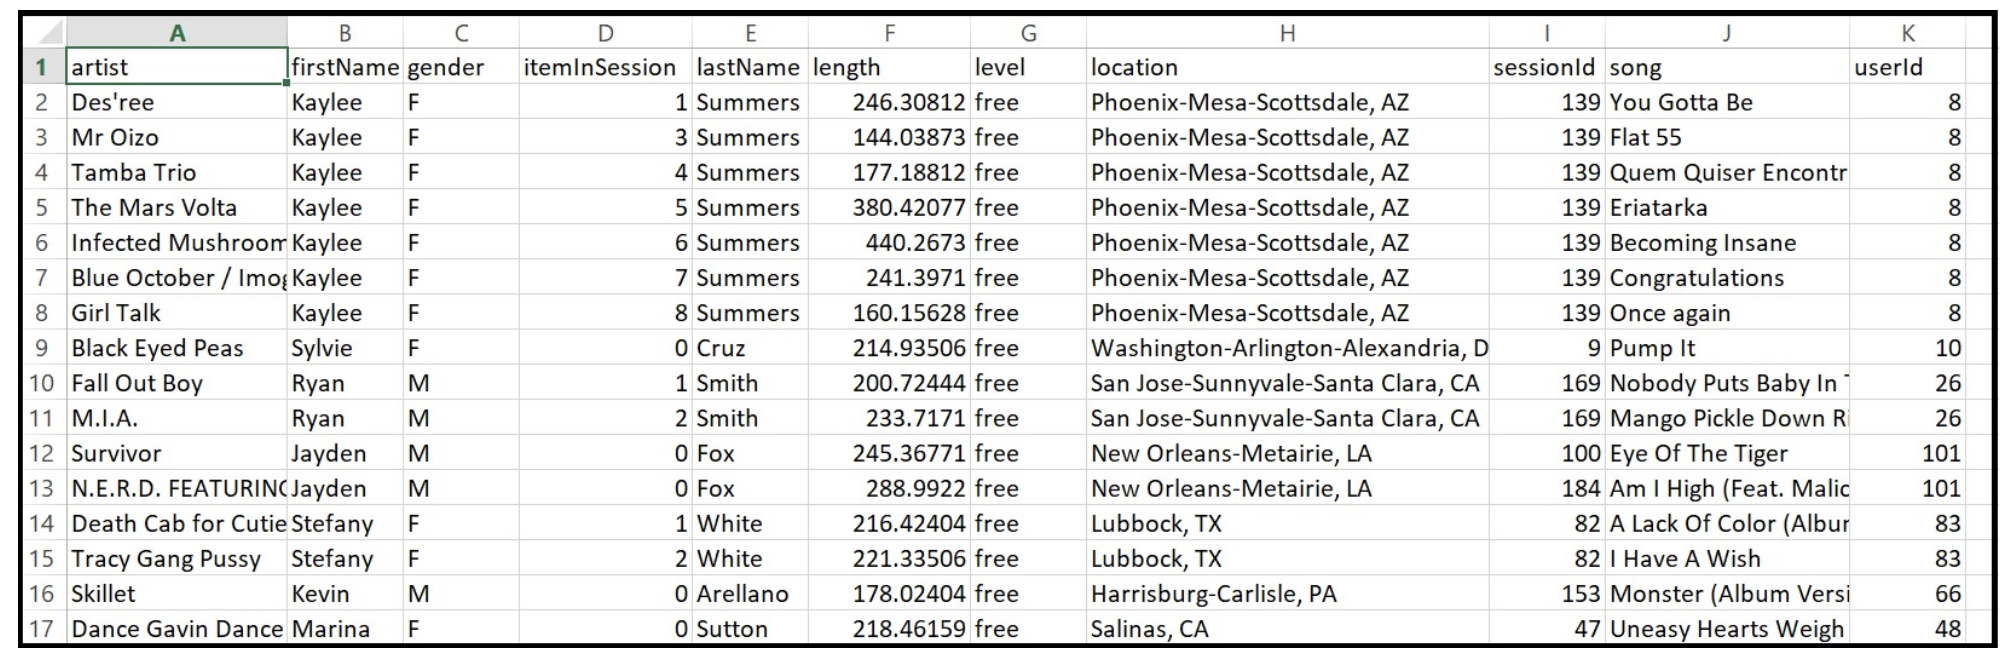

#### Creating a Cluster

In [13]:

from cassandra.cluster import Cluster
cluster = Cluster(['127.0.0.1'])

session = cluster.connect()

#### Create Keyspace

In [14]:
try:
    session.execute("""
    CREATE KEYSPACE IF NOT EXISTS udacity 
    WITH REPLICATION = 
    { 'class' : 'SimpleStrategy', 'replication_factor' : 1 }"""
)

except Exception as e:
    print(e)

#### Set Keyspace

In [15]:
try:
    session.set_keyspace('udacity')
except Exception as e:
    print(e)

### 1. Getting the artist, song title and song's length in the music app history that was heard during  sessionId = 338, and itemInSession  = 4

In [16]:
query = "CREATE TABLE IF NOT EXISTS songs_library"
query = query+ "(sessionId int,itemInSession int,artist text,song text, length float, primary key(sessionId,itemInSession))"
try:
    session.execute(query)
except Exception as e:
    print(e)


In [17]:
file = 'event_datafile_new.csv'

with open(file, encoding = 'utf8') as f:
    csvreader = csv.reader(f)
    next(csvreader) 
    for line in csvreader:
        query = "INSERT INTO songs_library(sessionId,itemInSession,artist,song,length)"
        query = query + "VALUES(%s,%s,%s,%s,%s)"
        session.execute(query, (int(line[8]),int(line[3]),line[0],line[9],float(line[5])))

#### Verifying that the data have been inserted into each table

In [18]:
## SELECT statement to verify the data was entered into the table
query = "select artist,song,length from songs_library where sessionId=338 and itemInSession=4"
try:
    rows = session.execute(query)
except Exception as e:
    print(e)
for row in rows:
    print(row.artist,row.song,row.length)

Faithless Music Matters (Mark Knight Dub) 495.30731201171875


### 2. Getting the name of artist, song (sorted by itemInSession) and user (first and last name) for userid = 10, sessionid = 182

In [19]:
query = "CREATE TABLE IF NOT EXISTS user_activity"
query = query+ "(userId int,sessionId int,itemInSession int,artist text, song text, firstname text, lastname text, PRIMARY KEY((userId,sessionId),itemInSession))"
try:
    session.execute(query)
except Exception as e:
    print(e)

In [20]:
file = 'event_datafile_new.csv'

with open(file, encoding = 'utf8') as f:
    csvreader = csv.reader(f)
    next(csvreader) 
    for line in csvreader:
        query = "INSERT INTO user_activity(userId,sessionId,itemInSession,artist,song,firstname,lastname)"
        query = query + "VALUES(%s,%s,%s,%s,%s,%s,%s)"
        session.execute(query, (int(line[10]),int(line[8]),int(line[3]),line[0], line[9], line[1], line[4]))

#### Verifying that the data have been inserted into each table

In [21]:

query = "select artist,song,firstname,lastname from user_activity where userId=10 and sessionId=182"
try:
    rows=session.execute(query)
except Exception as e:
    print(e)
for row in rows:
    print(row.artist,row.song,row.firstname,row.lastname)

Down To The Bone Keep On Keepin' On Sylvie Cruz
Three Drives Greece 2000 Sylvie Cruz
Sebastien Tellier Kilometer Sylvie Cruz
Lonnie Gordon Catch You Baby (Steve Pitron & Max Sanna Radio Edit) Sylvie Cruz


### 3. Getting every user name (first and last) in my music app history who listened to the song 'All Hands Against His Own'

In [25]:
query = "CREATE TABLE IF NOT EXISTS song_listners"
query = query+ "(song text,userId int, firstname text, lastname text, PRIMARY KEY(song,userId))"
try:
    session.execute(query)
except Exception as e:
    print(e)

In [ ]:
file = 'event_datafile_new.csv'

with open(file, encoding = 'utf8') as f:
    csvreader = csv.reader(f)
    next(csvreader) # skip header
    for line in csvreader:
        query = "INSERT INTO song_listners(song,userId,firstname, lastname)"
        query = query + "VALUES(%s,%s,%s,%s)"
        session.execute(query, (line[9], int(line[10]),line[1], line[4] ))

#### Verifying that the data have been inserted into each table

In [ ]:
query="select firstname,lastname from song_listners where song='All Hands Against His Own'"
try:
    rows = session.execute(query)
except Exception as e:
    print(e)
for row in rows:
    print(row.firstname,row.lastname)

### Drop the tables before closing out the sessions

In [ ]:
query= "drop table songs_library"
try:
    session.execute(query)
except Exception as e:
    print(e)

In [ ]:
query= "drop table user_activity"
try:
    session.execute(query)
except Exception as e:
    print(e)

In [ ]:
query= "drop table song_listners"
try:
    session.execute(query)
except Exception as e:
    print(e)

### Close the session and cluster connection¶

In [ ]:
session.shutdown()
cluster.shutdown()